In [2]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install torch
!pip install matplotlib
!pip install scipy
!pip install scikit-learn
!pip install pyWavelets


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from scipy.fft import fft, ifft
import pywt

### GPU SETTING

In [4]:
if torch.cuda.is_available():
    # 사용 가능한 GPU의 개수
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")

    # Device 세팅
    device = torch.device("cuda")
    print("GPU is available and set as the current device.")

    # 현재 device로 설정된 GPU 확인
    current_device = torch.cuda.current_device()
    print(f"Current GPU Device: index[{current_device}]")
    
    # 현재 device로 설정된 GPU의 이름 출력
    print(f"Device name: {torch.cuda.get_device_name(current_device)}")
    
    
else:
    print("GPU is not available, using CPU instead.")
    device = torch.device("cpu")

Number of GPUs available: 1
GPU is available and set as the current device.
Current GPU Device: index[0]
Device name: NVIDIA GeForce GTX 1050 Ti


### DATA SETTING

In [5]:
sensor1 = pd.read_csv("raw_data/g1_sensor1.csv",names=["time","normal","type1","type2","type3"])
sensor2 = pd.read_csv("raw_data/g1_sensor2.csv",names=["time","normal","type1","type2","type3"])
sensor3 = pd.read_csv("raw_data/g1_sensor3.csv",names=["time","normal","type1","type2","type3"])
sensor4 = pd.read_csv("raw_data/g1_sensor4.csv",names=["time","normal","type1","type2","type3"])

In [6]:
print("sensor 1의 데이터 크기",sensor1.shape) # 190218개의 행, 5의 열
print("sensor 1의 데이터 크기",sensor2.shape)
print("sensor 1의 데이터 크기",sensor3.shape)
print("sensor 1의 데이터 크기",sensor4.shape)

sensor 1의 데이터 크기 (190218, 5)
sensor 1의 데이터 크기 (184211, 5)
sensor 1의 데이터 크기 (196079, 5)
sensor 1의 데이터 크기 (183969, 5)


In [7]:
from scipy import interpolate
x_new = np.arange(0,140,0.001) # 0,0.001,0.002,,,,,,139.999
y_new1 = []
y_new2 = []
y_new3 = []
y_new4 = []

# 모든 센서의 각 타입 데이터 별로 선형 보간을 수행한 결과를 추출
for item in ["normal","type1","type2","type3"]:
    f_linear1 = interpolate.interp1d(sensor1["time"],sensor1[item],kind="linear") 
    y_new1.append(f_linear1(x_new)) 

    f_linear2 = interpolate.interp1d(sensor2["time"],sensor2[item],kind="linear")
    y_new2.append(f_linear2(x_new))
    f_linear3 = interpolate.interp1d(sensor3["time"],sensor3[item],kind="linear")
    y_new3.append(f_linear3(x_new))
    f_linear4 = interpolate.interp1d(sensor4["time"],sensor4[item],kind="linear")
    y_new4.append(f_linear4(x_new))


In [8]:
sensor1

,time,normal,type1,type2,type3
0,0.000000,-0.853307,-3.464579,0.555219,3.919664
1,0.000736,-0.740463,-2.448986,-0.234687,4.145351
2,0.001472,-0.138630,-1.922383,-0.009000,2.941685
3,0.002208,0.049443,-0.906790,-0.272301,2.603155
4,0.002944,-0.289088,-0.568259,-0.986978,1.361874
...,...,...,...,...,...
190213,139.996768,-1.156354,-2.696750,0.844491,-2.109427
190214,139.997504,-0.930666,-1.380241,0.919720,-2.222270
190215,139.998240,-0.554521,-2.132532,0.731647,-2.109427
190216,139.998976,-1.419655,-2.433448,1.183022,-3.087405


In [9]:
# 시간축을 기준으로, 모든 센서에서 추출된 데이터를 이어붙인다.
normal_ = pd.concat([sensor1["normal"],sensor2["normal"],sensor3["normal"],sensor4["normal"]],axis=1) # 각 센서에서 추출된 normal 데이터 
type1_ = pd.concat([sensor1["type1"],sensor2["type1"],sensor3["type1"],sensor4["type1"]],axis=1) # Type 1 이상치 데이터
type2_ = pd.concat([sensor1["type2"],sensor2["type2"],sensor3["type2"],sensor4["type2"]],axis=1) # Type 2 이상치 데이터
type3_ = pd.concat([sensor1["type3"],sensor2["type3"],sensor3["type3"],sensor4["type3"]],axis=1) # Type 3 이상치 데이터

# 어디 센서에서 나온 결과인지, 열의 이름 달기
normal_.columns = ["s1","s2","s3","s4"]
type1_.columns = ["s1","s2","s3","s4"]
type2_.columns = ["s1","s2","s3","s4"]
type3_.columns = ["s1","s2","s3","s4"]

In [10]:
normal_

,s1,s2,s3,s4
0,-0.853307,0.048823,-0.437626,-1.116226
1,-0.740463,-0.029477,-0.437626,-0.379672
2,-0.138630,-0.029477,0.280889,-1.271290
3,0.049443,0.009673,0.280889,-0.612268
4,-0.289088,0.009673,-0.257997,-0.689800
...,...,...,...,...
196074,NaN,NaN,-0.257427,NaN
196075,NaN,NaN,0.146738,NaN
196076,NaN,NaN,0.371273,NaN
196077,NaN,NaN,0.416181,NaN


### DATA ANALYSIS

- 기본적인 분포
    * 주파수가 현재 normal, type1, type2, type3가 달라서, 정규 분포가 다름

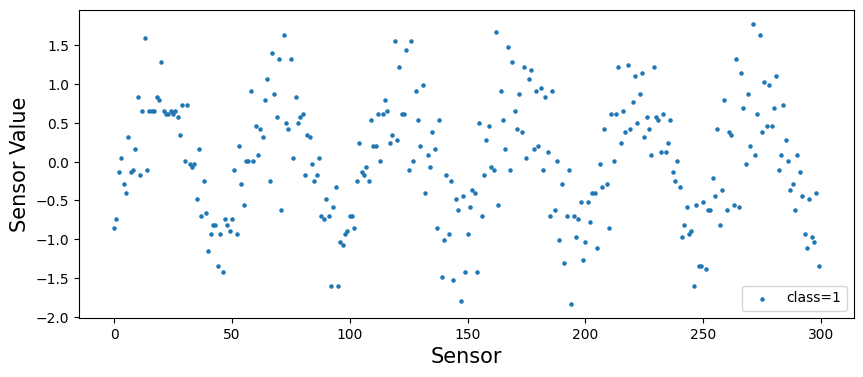

In [11]:
plt.figure(figsize=(10,4))
plt.scatter(range(0,300),normal_["s1"][:300],label="class="+str(1),marker='o',s =5) # x축: (0,300), y축: normal_["s1"][:300]
# plt.scatter(range(0,300),type1_["s1"][:300],label="class="+str(2),marker='o',s =5)
# plt.scatter(range(0,300),type2_["s1"][:300],label="class="+str(3),marker='o',s =5)
# plt.scatter(range(0,300),type3_["s1"][:300],label="class="+str(4),marker='o',s =5)

plt.legend(loc="lower right")
plt.xlabel("Sensor",fontsize=15)
plt.ylabel("Sensor Value",fontsize=15)
plt.show()
plt.close()

- 주어진 주파수를 Morlet 웨이블릿을 활용해 CWT변환

(196079,)


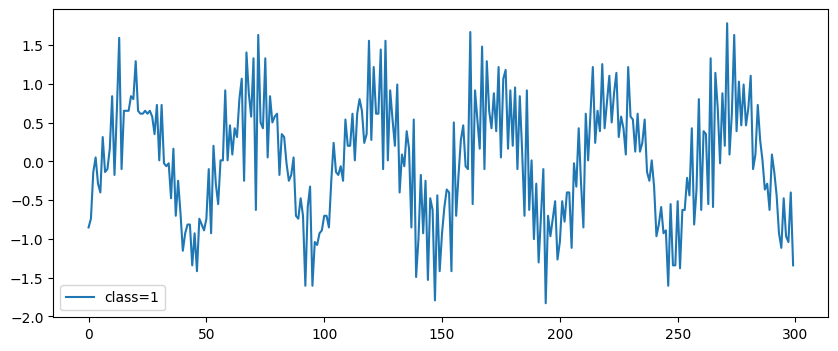

In [12]:
# 웨이블릿 생성 코드
def psi(T, f0=6):
    '''
	  T : parameter for adjusting length of wavelet
	  f0 : parameter for time-frequenct resolution trade off 
    '''
    x = np.linspace(-2 * np.pi, 2 * np.pi, T)
    return (np.pi ** -0.25) * np.exp(1j * f0 * x - x ** 2 / 2)

# 특정 웨이블릿과 주어진 신호 사이의 상관계수 Convolution 연산 코드
def wavelet_convolution(tup):
    f = tup[0]
    T = tup[1]
    f_len = np.shape(f)[0]
    f_hat = np.append(f, np.zeros(T))
    h = psi(T)
    h_hat = np.append(h, np.zeros(f_len))
    return ifft(fft(f_hat)*fft(h_hat))[round(T/2) : round(T/2) + f_len]

# 전체 시간의 CWT 출력
def cwt(f, t0 = 20):
    '''
    f : input signal
    t0 : minimum length of wavelet
    '''
    f_len = np.shape(f)[0]
    result = np.array(list(map(wavelet_convolution, [(f, x) for x in range(t0, f_len, 10)])))
    return result

# 기본 Input 시그널 확인
input_signal = normal_["s1"]
print(np.shape(input_signal))
plt.figure(figsize=(10,4))
plt.plot(range(0, 300), input_signal[:300], label="class=" + str(1))
plt.legend()
plt.show()




/home/seonghun/.pyenv/versions/3.10.11/envs/ml-job/lib/python3.10/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


[[0.20302589 0.13929442 0.16627902 ...        nan        nan        nan]
 [0.35521996 0.45369272 0.3574865  ...        nan        nan        nan]
 [0.4357602  0.48614456 0.39398545 ...        nan        nan        nan]
 ...
 [0.52009324 0.63149681 0.48555659 ...        nan        nan        nan]
 [0.7468632  1.09739878 1.09087859 ...        nan        nan        nan]
 [0.94842019 1.05689358 1.21349246 ...        nan        nan        nan]]


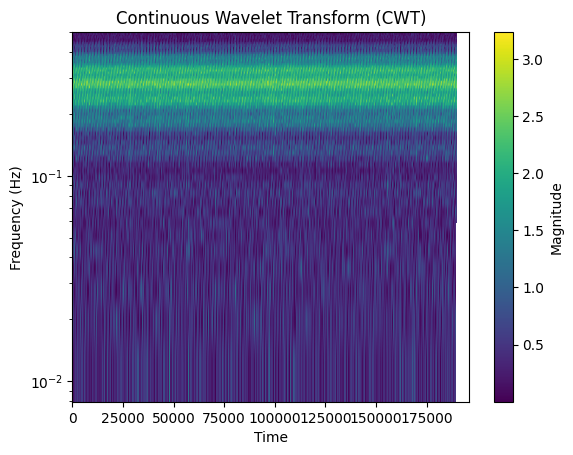

In [15]:
# 라이브러리를 활용한 CWT 변환
wavelet = 'cmor'
scales = np.arange(1,64) # 스케일이 커질 수록, 낮은 주파수 성분을 잡아낼 수 있음
coefficients, frequencies = pywt.cwt(input_signal, scales, wavelet)
# CWT 결과를 시각화합니다.
print(np.abs(coefficients))
plt.imshow(np.abs(coefficients), extent=[0, len(input_signal), frequencies[-1], frequencies[0]], aspect='auto')
plt.yscale('log')
plt.colorbar(label='Magnitude')
plt.title('Continuous Wavelet Transform (CWT)')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time')
plt.show()

### CWT 변환 적용

In [16]:
# apply_cwt 함수 정의: 각 센서 데이터에 대해 CWT를 적용합니다.
def apply_cwt(data, scales, wavelet='cmor'):
    max_freqs = []
    for column in data:
        sensor_data = data[column].values  # Pandas Series를 numpy 배열로 변환
        if sensor_data.ndim != 1:
            raise ValueError(f"Data for sensor {column} is not 1-dimensional.")
        # 연속 웨이블릿 변환 적용
        cwt_matrix, frequencies = pywt.cwt(sensor_data, scales, wavelet)
        # 해당 시계열의 cwt_matrix의 절댓값이 가장 큰 값의 frequencies을 넣어준다.
        # Find the index of the max coefficient at each time point across all scales
        max_indices = np.argmax(np.abs(cwt_matrix), axis=0)
        # Record the frequencies corresponding to each max coefficient
        max_freqs.append(frequencies[max_indices])
    # numpy 배열로 변환
    return np.column_stack(max_freqs)

wavelet = 'cmor'
scales = np.arange(1,128) # 스케일이 커질 수록, 낮은 주파수 성분을 잡아낼 수 있음-> 이거 그냥 64가 제일 잘 나와서 이걸로 함

# 각 데이터셋에 대해 CWT 변환 적용
normal_cwt = apply_cwt(normal_, scales)
type1_cwt = apply_cwt(type1_, scales)
type2_cwt = apply_cwt(type2_, scales)
type3_cwt = apply_cwt(type3_, scales)

# CWT 결과를 시각화하는 함수 정의
def visualize_cwt(coefficients, sensor_index, scales):
    plt.figure(figsize=(10, 4))
    plt.imshow(np.abs(coefficients[sensor_index]), extent=[0, len(coefficients[sensor_index][0]), scales[-1], scales[0]], aspect='auto', cmap='viridis')
    plt.yscale('log')
    plt.colorbar(label='Magnitude')
    plt.title(f'Continuous Wavelet Transform (CWT) - Sensor {sensor_index + 1}')
    plt.ylabel('Scale')
    plt.xlabel('Time')
    plt.show()

# # 각 센서에 대한 CWT 결과를 시각화
# for i in range(normal_cwt.shape[0]):  # normal_cwt의 첫 번째 차원은 센서의 개수를 나타냄
#     visualize_cwt(normal_cwt, i, scales)

/home/seonghun/.pyenv/versions/3.10.11/envs/ml-job/lib/python3.10/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


### DATA PREPROCESSING

In [17]:
M =15 # 이동평균 필터 사이즈
def apply_moving_average(data):
    # 이동 평균 적용 및 데이터 재구성
    temp = [np.convolve(data[col], np.ones(M), 'valid') / M for col in data.columns]
    return np.column_stack(temp)

# 이동 평균 필터 적용 -> 노이즈 제거용
normal_ma = apply_moving_average(normal_)
type1_ma = apply_moving_average(type1_)
type2_ma = apply_moving_average(type2_)
type3_ma = apply_moving_average(type3_)
# CWT 결과와 이동평균 결과 결합
print(np.shape(normal_ma),np.shape(normal_cwt))
# CWT 결과 중 필요한 부분만 슬라이싱하여 이동 평균 결과와 결합
start_index = 14  # 이동 평균을 적용했을 때 데이터가 얼마나 줄어드는지에 따라 조정
normal_features = np.concatenate((normal_ma, normal_cwt[start_index:, :]), axis=1)
type1_features = np.concatenate((type1_ma, type1_cwt[start_index:, :]), axis=1)
type2_features = np.concatenate((type2_ma, type2_cwt[start_index:, :]), axis=1)
type3_features = np.concatenate((type3_ma, type3_cwt[start_index:, :]), axis=1)
print(np.shape(normal_features))

(196065, 4) (196079, 4)
(196065, 8)


In [27]:
# 정규화
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(normal_features) # normal_데이터셋의 데이터 분포가 어떻게 정규화되어 있는지 학습

# normal_ 데이터셋 분포에 맞게 다른 모든 데이터 셋의 분포를 전환
normal= scaler.fit_transform(normal_features)
type1 = scaler.transform(type1_features)
type2= scaler.transform(type2_features)
type3= scaler.transform(type3_features)

### DATA SPLIT ->(Train, Valid, Test)

In [28]:
print(normal)
print('------------------------------------------------')
print('normal data size = ', normal.shape)

[[5.77007729e-01 5.43438732e-01 2.61750705e-01 ... 0.00000000e+00
  5.20325203e-04 1.06292517e-03]
 [6.36953695e-01 5.42212695e-01 3.37325276e-01 ... 0.00000000e+00
  1.22033898e-03 3.93545848e-04]
 [6.92403711e-01 5.42212695e-01 3.97784933e-01 ... 0.00000000e+00
  2.14285714e-03 9.05040379e-04]
 ...
 [           nan            nan 7.01042669e-01 ... 1.00000000e+00
  6.61333333e-01 1.00000000e+00]
 [           nan            nan 7.56464025e-01 ... 1.00000000e+00
  6.61333333e-01 1.00000000e+00]
 [           nan            nan 7.06080985e-01 ... 1.00000000e+00
  8.78048780e-03 1.00000000e+00]]
------------------------------------------------
normal data size =  (196065, 8)


In [29]:
# 끝에 NAN 쓰레기값, 초반에 불안정함때문에 중간 100,000개만 데이터로 사용
normal = normal[30000:130000][:]
type1 = type1[30000:130000][:]
type2 = type2[30000:130000][:]
type3 = type3[30000:130000][:]
print(normal)
print('------------------------------------------------')
print('normal data size = ', normal.shape)

[[1.66086629e-01 2.41424030e-01 6.55402714e-01 ... 1.57232704e-03
  1.19466667e-01 8.36940837e-02]
 [2.03552856e-01 3.01499874e-01 7.41053892e-01 ... 2.90151903e-03
  4.94845361e-03 5.92592593e-02]
 [2.51509632e-01 3.48089308e-01 7.05785765e-01 ... 8.36940837e-02
  1.40307692e-01 5.92592593e-02]
 ...
 [8.90692264e-01 6.77606016e-01 6.47190815e-01 ... 1.31061599e-03
  6.83146067e-03 8.28157350e-04]
 [9.10174704e-01 6.69023752e-01 6.72382335e-01 ... 8.28157350e-04
  7.62790698e-03 0.00000000e+00]
 [9.14670649e-01 6.84962237e-01 7.02612162e-01 ... 1.26336249e-02
  9.72151899e-03 8.28157350e-04]]
------------------------------------------------
normal data size =  (100000, 8)


In [30]:
# 데이터 분배, train = 60,000개, valid = 20,000개, test = 20,000개 
normal_train = normal[:][:60000]; normal_valid = normal[:][60000:80000]; normal_test =normal[:][80000:]
type1_train = type1[:][:60000]; type1_valid = type1[:][60000:80000]; type1_test =type1[:][80000:]
type2_train = type2[:][:60000]; type2_valid = type2[:][60000:80000]; type2_test =type2[:][80000:]
type3_train = type3[:][:60000]; type3_valid = type3[:][60000:80000]; type3_test =type3[:][80000:]

# 데이터 합치기
train = np.concatenate((normal_train,type1_train,type2_train,type3_train))
valid = np.concatenate((normal_valid,type1_valid,type2_valid,type3_valid))
test = np.concatenate((normal_test,type1_test,type2_test,type3_test))
print("train data의 형태:", train.shape) # normal_train -> type1_train -> type2_train -> type3_train: 같은 분포
print("valid data의 형태:", valid.shape)
print(" test data의 형태:", test.shape)

train data의 형태: (240000, 8)
valid data의 형태: (80000, 8)
 test data의 형태: (80000, 8)


In [31]:
# 모델이 예측한 결과값을 담을 데이터 구조 생성, 정답 데이터
train_label = np.concatenate((np.full((60000,1),0), np.full((60000,1),1),
np.full((60000,1),2), np.full((60000,1),3)))
valid_label = np.concatenate((np.full((20000,1),0), np.full((20000,1),1),
np.full((20000,1),2), np.full((20000,1),3)))
test_label = np.concatenate((np.full((20000,1),0), np.full((20000,1),1),
np.full((20000,1),2), np.full((20000,1),3)))

In [32]:
# train data, valid data, test data 전부 index 셔플
idx = np.arange(train.shape[0]); np.random.shuffle(idx)
train = train[:][idx]; train_label = train_label[:][idx]

idx_v = np.arange(valid.shape[0]); np.random.shuffle(idx_v)
valid = valid[:][idx_v]; valid_label = valid_label[:][idx_v]

idx_t = np.arange(test.shape[0]); np.random.shuffle(idx_t);
test = test[:][idx_t]; test_label = test_label[:][idx_t]

In [33]:
# 토치 텐서로 변환, 그냥 좀 절삭
x_train = torch.from_numpy(train).float()
y_train = torch.from_numpy(train_label).float().T[0]
x_valid = torch.from_numpy(valid).float()
y_valid = torch.from_numpy(valid_label).float().T[0]
x_test = torch.from_numpy(test).float()
y_test = torch.from_numpy(test_label).float().T[0]
print("변경 전")
train

변경 전


array([[ 9.07013483e-01,  1.06466549e-01,  3.84146099e-01, ...,
         7.60582011e-02,  9.33333333e-04,  5.92592593e-02],
       [ 3.18575646e-01,  6.11146191e-01,  6.81627444e-01, ...,
         6.78334012e-04,  1.51724138e-03,  2.17086835e-02],
       [ 9.46549169e-01,  7.78533821e-01,  6.62379581e-01, ...,
         6.40589569e-02,  8.78048780e-03,  2.56613757e-02],
       ...,
       [-5.99627866e-01, -2.67618570e-01,  4.12289758e-01, ...,
         2.80612245e-02,  2.14285714e-03,  5.13538749e-02],
       [ 2.27235625e-01,  8.05038460e-01,  8.44993516e-01, ...,
         6.40589569e-02,  4.11881188e-03,  5.50595238e-02],
       [-1.95200459e-01,  1.02112398e+00,  2.18472486e-01, ...,
         2.80612245e-02,  4.73469388e-03,  2.80612245e-02]])

In [34]:
print("변경 후")
x_train

변경 후


tensor([[ 9.0701e-01,  1.0647e-01,  3.8415e-01,  ...,  7.6058e-02,
          9.3333e-04,  5.9259e-02],
        [ 3.1858e-01,  6.1115e-01,  6.8163e-01,  ...,  6.7833e-04,
          1.5172e-03,  2.1709e-02],
        [ 9.4655e-01,  7.7853e-01,  6.6238e-01,  ...,  6.4059e-02,
          8.7805e-03,  2.5661e-02],
        ...,
        [-5.9963e-01, -2.6762e-01,  4.1229e-01,  ...,  2.8061e-02,
          2.1429e-03,  5.1354e-02],
        [ 2.2724e-01,  8.0504e-01,  8.4499e-01,  ...,  6.4059e-02,
          4.1188e-03,  5.5060e-02],
        [-1.9520e-01,  1.0211e+00,  2.1847e-01,  ...,  2.8061e-02,
          4.7347e-03,  2.8061e-02]])

In [35]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# 데이터셋 생성 및 배치사이즈로 미리 나누며 iterator 생성
BATCH_SIZE = 5000
train = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train, batch_size =BATCH_SIZE, shuffle=True)
valid = TensorDataset(x_valid, y_valid)
valid_dataloader = DataLoader(valid, batch_size =len(x_valid), shuffle=False)
test = TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test, batch_size =len(x_valid), shuffle=False)

### SET AI MODEL

In [ ]:
class KAMP_DNN(nn.Module):
    def __init__(self):
        super(KAMP_DNN, self).__init__()
        self.layer1 = nn.Linear(in_features =4, out_features =100)
        self.layer2 = nn.Linear(in_features =100, out_features =100)
        self.layer3 = nn.Linear(in_features =100, out_features =100)
        self.layer4 = nn.Linear(in_features =100, out_features =4)

        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
    def forward(self, input):
        out =self.layer1(input)
        out =self.relu(out)
        out =self.dropout(out)

        out =self.layer2(out)
        out =self.relu(out)
        out =self.dropout(out)

        out =self.layer3(out)
        out =self.relu(out)
        out =self.dropout(out)

        out =self.layer4(out)
        return out

model_check = KAMP_DNN()
print(model_check)

In [36]:
class KAMP_CNN(nn.Module):
    def __init__(self):
        super(KAMP_CNN, self).__init__()
        self.conv1 = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=100, kernel_size=2, stride=1, padding='same'),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=1, stride=1),
        nn.Dropout(p=0.2))

        self.conv2 = nn.Sequential(
        nn.Conv1d(in_channels=100, out_channels=100, kernel_size=2, stride=1, padding='same'),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=1, stride=1),
        nn.Dropout(p=0.2))

        self.conv3 = nn.Sequential(
        nn.Conv1d(in_channels=100, out_channels=100, kernel_size=2, stride=1, padding='same'),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=1, stride=1),
        nn.Dropout(p=0.2))

        self.conv4 = nn.Sequential(
        nn.Conv1d(in_channels=100, out_channels=4, kernel_size=2, stride=1, padding='same'),
        nn.BatchNorm1d(4),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=1, stride=1))

        self.final_pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(4, 4)
        
    def forward(self, input):
        input = input.unsqueeze(1)
        out =self.conv1(input)
        # out = self.conv2(out)
        # out = self.conv3(out)
        out =self.conv4(out)
        out =self.final_pool(out)
        out =self.linear(out.squeeze(-1))
        return out
model_check = KAMP_CNN()
print(model_check)

KAMP_CNN(
  (conv1): Sequential(
    (0): Conv1d(1, 100, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv4): 

In [ ]:
print('--------------------------------------------------------------------')
input = torch.tensor([[[0.0, 6.0, 9.0, 1.0]]])
print('"input is same below."')
print(input)
print('--------------------------------------------------------------------')
model = nn.Conv1d(1, 4, 2, bias =False)
model.weight.data = torch.zeros(model.weight.data.size())
model.weight.data[:, :, :2] =1
print('"kernal is same below."')
print(model.weight.data)
print('--------------------------------------------------------------------')
output = model(input)
print('"output is same below (without bias)."')
print(output)
print('--------------------------------------------------------------------')
model1 = nn.Conv1d(1, 4, 2)
model1.weight.data = torch.zeros(model1.weight.data.size())
model1.weight.data[:, :, :2] =1
output = model1(input)
print('"output is same below (with bias)."')
print(output)
print('--------------------------------------------------------------------')

In [ ]:
import torch
import torch.nn as nn
class KAMP_RNN(nn.Module):
    def __init__(self):
        super(KAMP_RNN, self).__init__()
        self.lstm = nn.LSTM(input_size =4, hidden_size =100, num_layers =2,
        batch_first=True, dropout =0.2)
        self.fc = nn.Linear(in_features =100, out_features =4)
    def forward(self, input):
        input = input.unsqueeze(1)
        out, _ =self.lstm(input)
        out = out.view(-1,100)
        output =self.fc(out)
        return output

model_check = KAMP_RNN()
print(model_check)

### TRAINING

In [37]:
# GPU: device
def train_model(model, criterion, optimizer, num_epoch, train_dataloader, PATH):
 # Model을 GPU로 이동
 model.to(device)

 
 loss_values = []
 loss_values_v = [] 
 accuracy_past =0
 for epoch in range(1, num_epoch +1):
    #---------------------- 모델 학습 ---------------------#
    model.train()
    batch_number =0
    running_loss =0.0
    for batch_idx, samples in enumerate(train_dataloader):
        # 데이터 GPU로 옮기기
        x_train, y_train = samples[0].to(device), samples[1].to(device) 

        # 변수 초기화
        optimizer.zero_grad()
        y_hat = model.forward(x_train)
        loss = criterion(y_hat,y_train.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch_number +=1

    loss_values.append(running_loss / batch_number)
 #---------------------- 모델 검증 ---------------------#
    model.eval()
    accuracy =0.0
    total =0.0
    for batch_idx, data in enumerate(valid_dataloader):
        x_valid, y_valid = data[0].to(device), data[1].to(device)

        v_hat = model.forward(x_valid)
        v_loss = criterion(v_hat,y_valid.long())
        _, predicted = torch.max(v_hat.data, 1)
        total += y_valid.size(0)
        accuracy += (predicted == y_valid).sum().item()
    loss_values_v.append(loss.item())
    accuracy = (accuracy / total)
 #----------------Check for early stopping---------------#
    if epoch % 1 ==0:
        print('[Epoch {}/{}] [Train_Loss: {:.6f} /Valid_Loss: {:.6f}]'.format(epoch, num_epochs, loss.item(),v_loss.item()))
        print('[Epoch {}/{}] [Accuracy : {:.6f}]'.format(epoch, num_epochs, accuracy))
    
    # checkpoint + early stopping
    if accuracy_past < accuracy:
        accuracy_past = accuracy
        torch.save(model.state_dict(), PATH + f'model_epoch_{epoch}_acc_{accuracy:.4f}.pt')
        print(f"Checkpoint saved at epoch {epoch} with validation accuracy {accuracy:.4f}.")

# return loss..
 return loss_values, loss_values_v

- For CNN

In [38]:
CNN_model = KAMP_CNN()
num_epochs =1000
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN_model.parameters())
PATH ='save/CNN/'
CNN_loss_values, CNN_loss_values_v = train_model(CNN_model, criterion, optimizer,
num_epochs, train_dataloader, PATH)

/home/seonghun/.pyenv/versions/3.10.11/envs/ml-job/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv1d(input, weight, bias, self.stride,


[Epoch 1/1000] [Train_Loss: 1.325967 /Valid_Loss: 1.328431]
[Epoch 1/1000] [Accuracy : 0.334175]
Checkpoint saved at epoch 1 with validation accuracy 0.3342.
[Epoch 2/1000] [Train_Loss: 1.279899 /Valid_Loss: 1.270172]
[Epoch 2/1000] [Accuracy : 0.431775]
Checkpoint saved at epoch 2 with validation accuracy 0.4318.
[Epoch 3/1000] [Train_Loss: 1.240959 /Valid_Loss: 1.221252]
[Epoch 3/1000] [Accuracy : 0.480775]
Checkpoint saved at epoch 3 with validation accuracy 0.4808.
[Epoch 4/1000] [Train_Loss: 1.197704 /Valid_Loss: 1.179165]
[Epoch 4/1000] [Accuracy : 0.497400]
Checkpoint saved at epoch 4 with validation accuracy 0.4974.
[Epoch 5/1000] [Train_Loss: 1.144883 /Valid_Loss: 1.137643]
[Epoch 5/1000] [Accuracy : 0.522150]
Checkpoint saved at epoch 5 with validation accuracy 0.5222.
[Epoch 6/1000] [Train_Loss: 1.100241 /Valid_Loss: 1.103248]
[Epoch 6/1000] [Accuracy : 0.570963]
Checkpoint saved at epoch 6 with validation accuracy 0.5710.
[Epoch 7/1000] [Train_Loss: 1.060653 /Valid_Loss: 1.

KeyboardInterrupt: 

- For RNN

In [ ]:
RNN_model = KAMP_RNN()
num_epochs =1000
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RNN_model.parameters())
PATH ='save/RNN/'
RNN_loss_values, RNN_loss_values_v = train_model(RNN_model, criterion, optimizer,
num_epochs, train_dataloader, PATH)

### TEST

In [39]:
def test_model(model, PATH):
    model = torch.load(PATH +'model.pt')
    #---------------------- 모델 시험 ---------------------#
    model.eval()
    total =0.0
    accuracy =0.0
    for batch_idx, data in enumerate(test_dataloader):
        x_test, y_test = data[0].to(device),data[1].to(device)

        t_hat = model(x_test)
        _, predicted = torch.max(t_hat.data, 1)
        total += y_test.size(0)
        accuracy += (predicted == y_test).sum().item()
    accuracy = (accuracy / total)
    #------------------------------------------------------#
    print(accuracy)

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
def draw_confusion_matrix(model, xt, yt, PATH):
    y_pred = []; y_true = []
    # 1. 모델 예측 결과 뽑기
    model.eval()
    y_hat = model(xt) # y_hat은 모델로 예측한 결과
    output = (torch.max(torch.exp(y_hat), 1)[1]).data.cpu().numpy() # 결과값만 추출 
    y_pred.extend(output)

    # 2. 실제 정답값 뽑기
    labels = y_test.data.cpu().numpy()
    y_true.extend(labels)
    # 분류 항목
    classes = ('Normal', 'Type1', 'Type2', 'Type3')

    # Confussion Matrix 생성
    plt.figure(figsize = (7,5))
    dlen = float(len(x_test)) # test data 크기 : 여기서는 80000
    cm = confusion_matrix(y_true, y_pred) 

    df_cm = pd.DataFrame(cm/dlen, index = [i for i in classes],columns = [i for i in classes])
    sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix", size=24, fontweight='bold')
    plt.xlabel("Predicted Label", size=16); plt.ylabel("Actual Label", size=16)
    plt.rc('xtick', labelsize=12); plt.rc('ytick', labelsize=12); plt.yticks(rotation=0)
    plt.savefig(PATH +'cm_output.png')

In [41]:
def plot_loss_graph(loss_values, loss_values_v):
    plt.figure()
    plt.plot(loss_values)
    plt.plot(loss_values_v)
    plt.title("Training & Validation Loss")
    plt.ylabel("loss", fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "validation"])
    plt.tight_layout()
    # 결과 저장
    plt.savefig(PATH +'lossplot_output.png')

- Check Accuracy

In [42]:
test_model(CNN_model,'save/CNN/')
# test_model(RNN_model,'save/RNN/')

0.25


- Check Confusion Matrix

In [ ]:
draw_confusion_matrix(CNN_model, x_test, y_test, 'save/CNN/')
draw_confusion_matrix(RNN_model, x_test, y_test, 'save/RNN/')

- Check Loss function

In [ ]:
plot_loss_graph(CNN_loss_values, CNN_loss_values_v)
plot_loss_graph(RNN_loss_values, RNN_loss_values_v)